<a href="https://colab.research.google.com/github/vlochub/MIT-Xpro-colab/blob/main/Module_15_Ensemble_Learning_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Module Import

In [ ]:
##!pip install xgboost>=2.0.1
!pip install --upgrade xgboost
import xgboost
print("xgboost version:", xgboost.__version__)

xgboost version: 3.0.5


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Dataset Import

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


The overall dataset has already been split into 70% train and 30% test datasets.

In [ ]:
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIT XPro/train.csv")
test_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MIT XPro/test.csv")

In [ ]:
train_df.head()

,CTR,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,gender,age
0,0.0000,10,17,3,2,0.0136,0.0146,0.0000,0.0000,male,41+
1,0.0761,13,30,2,1,0.0373,0.0465,0.0382,0.0581,male,13-18
2,0.0426,12,14,1,1,0.0254,0.0310,0.0255,0.0323,male,13-18
3,0.0000,5,19,3,2,0.0178,0.0076,0.0035,0.0017,female,25-30
4,0.0068,11,17,2,2,0.0096,0.0069,0.0294,0.0171,female,19-24


In [ ]:
y_train = train_df.pop('CTR')
y_test = test_df.pop('CTR')

# Helper Functions

We will use some functions to evaluate results:


*   MAE (mean absolute error)
*   RMSE (root mean squared error)
*   OSR2 (out of sample R2)

We will apply these to the test set always so that our metrics are out-of-sample

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def OSR2(y_true, y_pred, training_mean):
  '''
  Calculates out-of-sample R-squared
  '''
  baseline_error = np.sum(np.square((training_mean - y_true)))
  model_error = np.sum(np.square((y_pred - y_true)))
  return 1.0 - model_error/baseline_error


def calc_metrics():
  print(f'OSR2: {OSR2(y_test, y_pred, y_train.mean()):.3f}')
  print(f'MAE: {mean_absolute_error(y_test, y_pred):.3f}')
  print(f'RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.3f}')


# Linear Regression

In [ ]:
train = train_df.copy()
test = test_df.copy()
train = pd.get_dummies(train, columns=['age','gender'], drop_first=True)
test = pd.get_dummies(test, columns=['age','gender'], drop_first=True)

In [ ]:
train.head()

,titleWords,adWords,depth,position,advCTR,advCTRInPos,queryCTR,queryCTRInPos,age_13-18,age_19-24,age_25-30,age_31-40,age_41+,age_unknown,gender_male,gender_unknown
0,10,17,3,2,0.0136,0.0146,0.0000,0.0000,False,False,False,False,True,False,True,False
1,13,30,2,1,0.0373,0.0465,0.0382,0.0581,True,False,False,False,False,False,True,False
2,12,14,1,1,0.0254,0.0310,0.0255,0.0323,True,False,False,False,False,False,True,False
3,5,19,3,2,0.0178,0.0076,0.0035,0.0017,False,False,True,False,False,False,False,False
4,11,17,2,2,0.0096,0.0069,0.0294,0.0171,False,True,False,False,False,False,False,False


In [ ]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(train, y_train)
y_pred = model.predict(test)
calc_metrics()

OSR2: 0.375
MAE: 0.036
RMSE: 0.060


In [ ]:
pd.DataFrame({"Variable": train.columns, "Coefficient": model.coef_})

,Variable,Coefficient
0,titleWords,-0.000522
1,adWords,0.000384
2,depth,0.001969
3,position,-0.006381
4,advCTR,0.448779
5,advCTRInPos,0.557652
6,queryCTR,0.008432
7,queryCTRInPos,0.459923
8,age_13-18,-0.000537
9,age_19-24,-0.004222


# CART for Regression

In [ ]:
train = train_df.copy()
test = test_df.copy()
train = pd.get_dummies(train, columns=['age','gender'])
test = pd.get_dummies(test, columns=['age','gender'])

In [ ]:
from sklearn.tree import DecisionTreeRegressor

Let's train a full tree first.

In [ ]:
tree = DecisionTreeRegressor(random_state=42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

OSR2: 0.110
MAE: 0.041
RMSE: 0.072


Really bad!

In [ ]:
tree = DecisionTreeRegressor(random_state=42)
path = tree.cost_complexity_pruning_path(train, y_train)

In [ ]:
alphas = path.ccp_alphas

In [ ]:
alphas[-10:]

array([5.60594121e-05, 6.78182339e-05, 7.82438153e-05, 9.48639975e-05,
       1.10524275e-04, 1.21605695e-04, 1.42269318e-04, 2.12454597e-04,
       3.79581119e-04, 1.54424559e-03])

In [ ]:
len(alphas)

3269

That's a lot of possible pruned trees. Let's select every 10th tree so that we get ~330 trees in total.

In [ ]:
alphas = alphas[::10]

In [ ]:
len(alphas)

327

In [ ]:
osr2_all = []

for alpha in alphas:
  tree = DecisionTreeRegressor(ccp_alpha=alpha, random_state=42).fit(train,y_train)
  y_pred = tree.predict(test)
  osr2 = OSR2(y_test, y_pred, y_train.mean())
  osr2_all.append(osr2)

What's the best OSR2?

In [ ]:
np.max(osr2_all)

np.float64(0.37074956875052256)

Nice improvement!

In [ ]:
opt_alpha = alphas[np.argmax(osr2_all)]

In [ ]:
tree = DecisionTreeRegressor(ccp_alpha=opt_alpha, random_state=42).fit(train,y_train)
y_pred = tree.predict(test)
calc_metrics()

OSR2: 0.371
MAE: 0.035
RMSE: 0.060


Very nice!

How big is this tree?

In [ ]:
tree.tree_.node_count, tree.tree_.max_depth

(41, 8)

In [ ]:
from sklearn.tree import plot_tree

In [ ]:
def viz_tree(tree, X, font=12, figsize=(16,10)):
  '''
  draws a CART tree
  '''
  plt.figure(figsize=figsize)  # set plot size (denoted in inches)
  _ = plot_tree(tree,
                feature_names=X.columns,
                filled=True,
                fontsize=font)

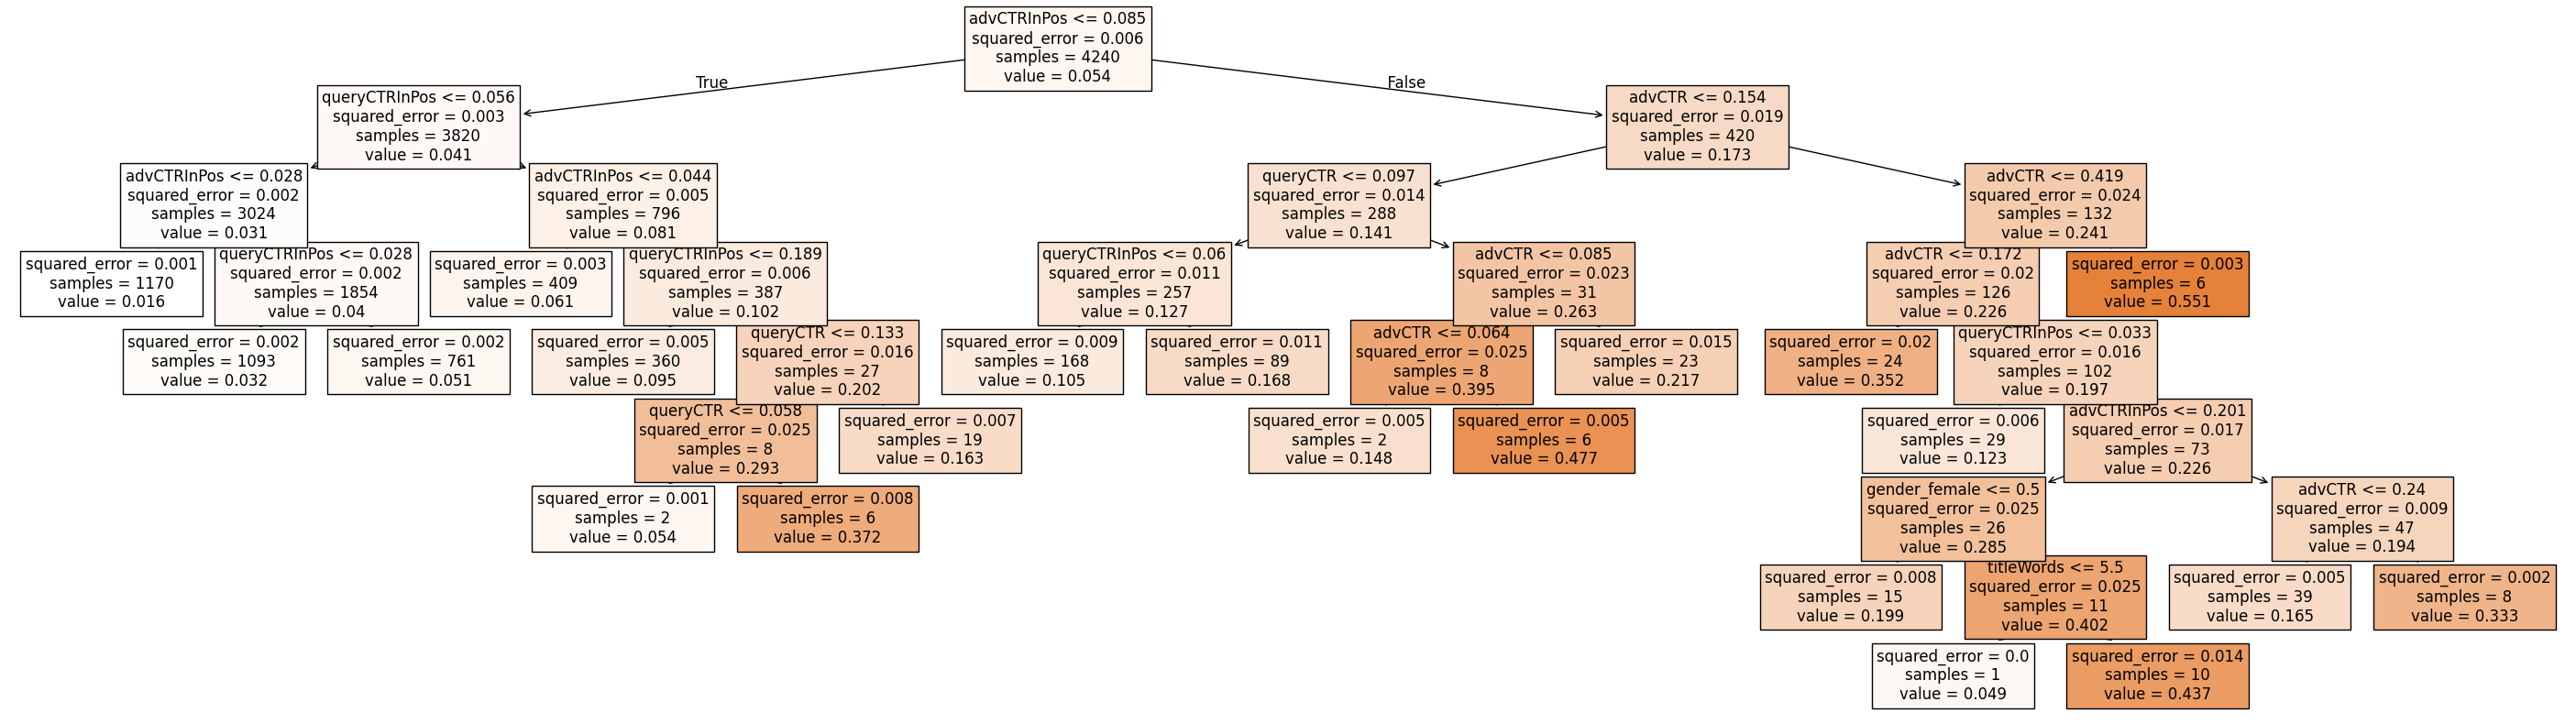

In [ ]:
viz_tree(tree, train, figsize=(36,10))

# Random Forests

In [ ]:
from sklearn.ensemble import RandomForestRegressor

Let's train a Random Forest model with all default settings.

In [ ]:
rf = RandomForestRegressor(random_state=42).fit(train,y_train)
y_pred = rf.predict(test)
calc_metrics()

OSR2: 0.467
MAE: 0.032
RMSE: 0.056


That handily outperforms Linear Regression and CART.

# XGBoost!

In [ ]:
import xgboost
import sklearn
print("scikit-learn version:", sklearn.__version__)
print("xgboost version:", xgboost.__version__)

scikit-learn version: 1.6.1
xgboost version: 3.0.4


In [ ]:
from xgboost import XGBRegressor

In [ ]:
model = XGBRegressor(random_state=42)

Let's train an XGBoost model with all default settings.

In [ ]:
model.fit(train, y_train)
y_pred = model.predict(test)

In [ ]:
calc_metrics()

OSR2: 0.465
MAE: 0.032
RMSE: 0.056


# Hyperparameter Optimization

## Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

Let's vary *three* hyperparameters simultaneously:

*   number of trees `n_estimators`: 10, 50, 100
*   maximum depth of the tree `max_depth`: 1,2,3,4,5
*   learning rate/shrinkage parameter $\eta$ i.e., `learning_rate`: 0.001, 0.01, 0.1, 0.3

This generates 60 hyperparameter combinations. For each, we will do 5-fold CV. So, an XGBoost model will be trained 300 times!



In [ ]:
param_grid = {'n_estimators': [10,50,100],
              'max_depth': [1,2,3,4,5],
              'learning_rate': [0.001, 0.01, 0.1, 0.3]}

In [ ]:
model = XGBRegressor(random_state=42)

In [ ]:
gcv = GridSearchCV(model,
                  param_grid=param_grid,
                  cv=5,
                  scoring='neg_mean_absolute_error')

In [ ]:
gcv.fit(train, y_train)

GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, feature_weights=None,
                                    gamma=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'learning_rate': [0.001, 0.01, 0.1, 0.3],
                         'max_depth': [1, 2, 3, 4, 5],
                         'n_estimators': [10, 50, 100]},
             scoring='neg_mean_absolute_error')

What's the combination with the lowest MAE?

In [ ]:
gcv.best_params_

{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}

In [ ]:
y_pred = gcv.best_estimator_.predict(test)
calc_metrics()

OSR2: 0.480
MAE: 0.032
RMSE: 0.055


## Random Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

In [ ]:
model = XGBRegressor(random_state=42)

In [ ]:
param_grid = {'n_estimators': range(10,1010,10),
              'max_depth': range(1,21),
              'learning_rate': np.linspace(0.001, 1.0, 50)}

**That**'s 100 x 20 x 50 = 100,000 combinations! We will try only 10 of these combinations using `RandomizedSearch`.

In [ ]:
rcv = RandomizedSearchCV(model,
                        param_distributions = param_grid,
                        cv=5,
                        n_iter=10,
                        scoring='neg_mean_absolute_error',
                        random_state=42)

In [ ]:
rcv.fit(train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          feature_weights=None, gamma=None,
                                          grow_policy=None,
                                          importance_type=None,
                                          interaction_constraint...
       0.51069388, 0.53108163, 0.55146939, 0.57185714, 0.5922449 ,
       0.61263265, 0.63302041, 0.65340816, 0.67379592, 0.69418367,
       0.71457143, 0.73495918, 0.75534694, 0.77573469, 0.79612245,
       0.8165102 , 0.83689796, 0.85728571, 0.87767347, 0.89806122,
       0.91844898, 0.93883673, 0.95922449, 0.97961224, 1.        ]),
                                        'max_depth': range(1, 21),
                                        'n_estimators': range(10, 1010, 10)},
                   random_state=42, scoring='neg_mean_absolute_error')

In [ ]:
rcv.best_params_

{'n_estimators': 660,
 'max_depth': 3,
 'learning_rate': np.float64(0.062163265306122456)}

In [ ]:
y_pred = rcv.best_estimator_.predict(test)
calc_metrics()

OSR2: 0.493
MAE: 0.032
RMSE: 0.054




---



---


**SUMMARY**

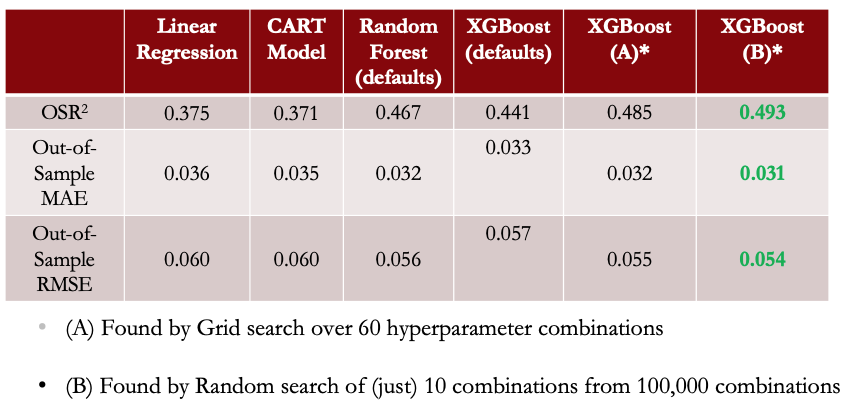



---



---



In [ ]:
pd.DataFrame(rcv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.146455,1.343756,0.015437,0.005748,960,18,0.143714,"{'n_estimators': 960, 'max_depth': 18, 'learni...",-0.040152,-0.035089,-0.033152,-0.033327,-0.032790,-0.034902,0.002742,4
1,4.271913,1.134580,0.039011,0.017327,610,9,0.001000,"{'n_estimators': 610, 'max_depth': 9, 'learnin...",-0.041371,-0.038866,-0.040061,-0.037325,-0.038742,-0.039273,0.001361,9
2,0.261480,0.013583,0.007415,0.000257,210,9,0.775735,"{'n_estimators': 210, 'max_depth': 9, 'learnin...",-0.042100,-0.037473,-0.036123,-0.037201,-0.035921,-0.037764,0.002249,6
3,0.472330,0.007092,0.009002,0.000386,870,9,0.551469,"{'n_estimators': 870, 'max_depth': 9, 'learnin...",-0.040610,-0.036369,-0.034342,-0.035237,-0.034570,-0.036226,0.002303,5
4,0.321597,0.012528,0.010329,0.000293,660,3,0.062163,"{'n_estimators': 660, 'max_depth': 3, 'learnin...",-0.036387,-0.032179,-0.033014,-0.030807,-0.032135,-0.032905,0.001879,1
5,0.967828,0.926208,0.017324,0.010547,870,4,0.836898,"{'n_estimators': 870, 'max_depth': 4, 'learnin...",-0.045123,-0.039580,-0.039370,-0.036845,-0.038722,-0.039928,0.002770,10
6,0.687322,0.185092,0.010043,0.001805,950,12,0.367980,"{'n_estimators': 950, 'max_depth': 12, 'learni...",-0.039261,-0.034905,-0.032432,-0.034325,-0.032881,-0.034761,0.002426,3
7,0.427191,0.036012,0.007889,0.000114,990,15,0.877673,"{'n_estimators': 990, 'max_depth': 15, 'learni...",-0.042956,-0.038457,-0.037355,-0.037898,-0.036928,-0.038719,0.002180,8
8,0.127594,0.014078,0.007088,0.000097,320,2,0.449531,"{'n_estimators': 320, 'max_depth': 2, 'learnin...",-0.037291,-0.032984,-0.034272,-0.032416,-0.033143,-0.034021,0.001742,2
9,0.327006,0.022709,0.010145,0.000128,640,3,0.612633,"{'n_estimators': 640, 'max_depth': 3, 'learnin...",-0.042321,-0.037835,-0.037546,-0.035067,-0.037192,-0.037992,0.002373,7


In [ ]:
from xgboost import plot_importance

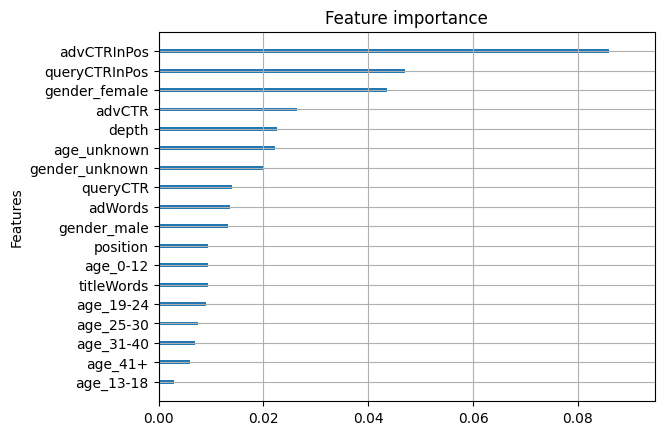

In [ ]:
plot_importance(rcv.best_estimator_, importance_type='gain', show_values=False, xlabel='');

## Next Steps

We invite you to:

*   try different hyperparameter combinations and improve upon these metrics
*   apply the same techniques – Cross-Validation, Grid Search and Random Search – to find good hyperparameter combinations for Random Forests as well.
